# **Needed Libraries**


In [1]:
# Data science 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
import pickle
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
# Single cell 
import scanpy as sc
import anndata as ad
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")
# Elbow point locator custom
from kneed import KneeLocator

# **Needed file dependancies**


In [2]:
from utils.plotting import  make_ellipses
from utils.optimization import optimizeGMM, optimizeSpectral

We load the file we saved from the dimensionality reduction stage along with the identified optimal number of principal components:


In [3]:
adata = sc.read("processed_datasets/dataset1.h5ad")
optimal_pca_component = 2
optimal_tsne_umap_components = 31

# **Stage 3: Clustering**


Having produced low dimensional representations of our original dataset via PCA, UMAP & TSNE. The goal of this stage is to identify the optimal number of cell states, by identifying the optimal number of components and covariance type for a Gaussian mixture model that describes the data. Our solution involves _three main options for the user to choose_ on either the PCA, UMAP or TSNE representations:

- **_Option 1._** We Enable users to leverage precomputed component means with their own outside of the pipeline preferred method, in this way the pipeline can be used for optimizing the covariance structure of the GMM through the utilization of BIC or AIC.
- **_Option 2._** We allow the automated identification of the ideal number of components and component means for the GMM by employing one of the following techniques:
  - **_Sub-option1._** :Optimized Spectral Clustering, maximizing the silhouette score coefficient, the GMM component precomputed means are identified by computing the mean point of each cluster.
  - **_Sub-option2._** : Leiden clustering, with the resolution parameter selected by the user, this serves the purpose of trying different parameters and intuitive analysis repeats in the pipeline context.
- **_Option 3._** Automatic optimization of both the number of components, as well as the covariance type via the use of BIC or AIC without any precomputed means.


## _Implementation of the GMM optimization function:_


In the "heart" of the optimization for the GMM model produced by the pipeline is a function called `optimizeGMM`, available in the `optimization.py` file of the utils folder.
It utilized the random sampler of the `optuna` library to finding the best number of components and covariance matrix structure, best initialization method and random state for the GMM based on the minimization either of the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC) scores.
The equation of BIC and AIC are:
$$BIC = -2 \times log(L) + k \times log(n)$$
$$AIC = -2 \times log(L) + 2 \times k$$
The log-likelihood takes into account how well the GMM explains the observed data. And both models penalize complex models by including a term that scales with the number of model parameters (k). However BIC scales the parameters by the $log$ of the number of observation in the dataset $n$, for this reason it selects less complex models than AIC which tends to overfit the training set, since the model parameters $k$ are multiplied by a scalar $= 2$. Subsequently BIC is the default metric for the optimization to minimize.

As described the function provides flexibility by allowing users to specify the range of components or provide precomputed means for initialization. It automates the parameter tuning process and returns the best parameters, the corresponding objective value, and the study object, which contains detailed optimization results.


## **Showcase of each option for fitting the optimal GMM model**

We present the implementation of the mentioned option, excluding option 1. where the user provides precomputed parameters, which is self-explanatory.
First of all we load the dataset representations computed in the previous stage.


In [4]:
X_pca = adata.obsm['X_pca'][:,:optimal_pca_component]
X_tsne = adata.obsm['X_tsne']
X_umap = adata.obsm['X_umap']
reps = [X_pca,X_tsne,X_umap]

To showcase each of the options, we create the `showcase_methods` which wraps around `optimizeGMM`, it optinaly takes as input precomputed means from the two options described above.

If no precomputed means are provied the function performs an optimization process for each input representation: PCA, TSNE, UMAP, using the Bayesian Information Criterion as the metric. It aims to find the best parameters for a Gaussian Mixture Model (GMM), including the number of components, initialization parameters, and covariance type. The optimized GMM is then fitted to the data Additionally, the function creates a plot that visualizes the GMM clusters using ellipses, with the title corresponding to the current dimensionality reduction method with a modified plotting function from the one provided by sklearn [here](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html).

On the other hand, if not_precomputed_means is set to False, the function utilizes the provided cluster_mean_reps as the initialization means for the GMM optimization. The number of components in the GMM is determined by the number of provided means. The remaining steps, such as fitting the GMM, calculating the BIC score, printing the best parameters and BIC score, and visualizing the clusters, are performed similarly to the previous case.


In [5]:
def showcase_methods(cluster_mean_reps = [],not_precomputed_means = False): 
  methods = ["PCA","TSNE","UMAP"]
  method_count = 0
  if not_precomputed_means:
    for i,X in enumerate(reps):
      best_params, best_value, _  = optimizeGMM(X = X,metric = "BIC",components_range =[2,10],n_trials=1000)
      gmm = GaussianMixture(n_components= best_params['n_components'], init_params=best_params['init_params'],covariance_type= best_params['covariance_type'],random_state= best_params['random_state'],max_iter=500)
      labels = gmm.fit_predict(X)
      gmm.bic(X)
      print("The best parameters after the optimization study are:", best_params)
      print(f"Best BIC score = ",best_value)
      make_ellipses(gmm,X,labels, title = methods[i])
  else:
    for X,means in zip(reps,cluster_mean_reps):
      best_params, best_value, _ = optimizeGMM(X = X,metric = "BIC",precomputed_means=means,n_trials=500)
      gmm = GaussianMixture(n_components=means.shape[0], means_init=means,covariance_type= best_params['covariance_type'],random_state= best_params['random_state'],max_iter=500)
      labels = gmm.fit_predict(X)
      gmm.bic(X)
      print("The best parameters after the optimization study are:", best_params)
      print(f"Best BIC score = ",best_value)
      make_ellipses(gmm,X,labels, title = methods[method_count])
      method_count +=1

### _Option 2: Automated Identification of Ideal Number of Components and Component Mean coordinates for GMM via pre-clustering_


#### **Suboption 1.: Optimized Spectral Clustering by Maximizing Silhouette Score Coefficient for precomputed GMM Component means**


Finding the precomputed means by spectral clustering serves the purpose of identifying cell clusters that are often not picked up by Gaussian Mixture Models (GMM) due to their initialization, which may miss irregularly shaped clusters. For the affinity matrix the default is the distance matrix produced nearest neighborts connectivity graph. Its important to note however that the optimization of the hyperparamters of spectral clustering with either the Calinski-Harabasz, Shilouete score or Davies Bouldin index can favor minim-variance shperical clusters and introduce some bias towards that shape.


In [6]:
cluster_mean_reps = []
affinity = "nearest_neighbors"
eval_metric = "silhouette_score"
direction = "maximize"
for X in reps:
  best_params, best_value, _ = optimizeSpectral(X = X, k_range =  [2,20], neighbors_range = [3,40], affinity = affinity, eval_metric = eval_metric, direction = direction, n_trials=50)
  sp = SpectralClustering(n_clusters=best_params['n_clusters'],n_neighbors=best_params['n_neighbors'],affinity=affinity, assign_labels= 'cluster_qr')
  labels = sp.fit_predict(X)
  unique_labels = np.unique(labels)
  cluster_means = [np.mean(X[labels == label], axis=0) for label in unique_labels]
  cluster_means = np.array(cluster_means)  
  cluster_mean_reps.append(cluster_means)
cluster_mean_reps

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[array([[ 3.2415812 , -0.05909563],
        [-3.145296  ,  0.05734038]], dtype=float32),
 array([[-4.672495 ,  1.8026197],
        [ 2.6863203, -3.172218 ]], dtype=float32),
 array([[ 6.5953617, 11.193458 ],
        [ 8.644947 ,  8.440659 ]], dtype=float32)]

Optimized with silhouette score maximization spectral clustering identifies $2$ clusters with the above mean points, we proceed to plot the components of the optimized fitted GMM models, utilizing the above precomputed means for the PCA, TSNE and UMAP representation.


  0%|          | 0/500 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'covariance_type': 'full', 'random_state': 455}
Best BIC score =  1793.14085550949


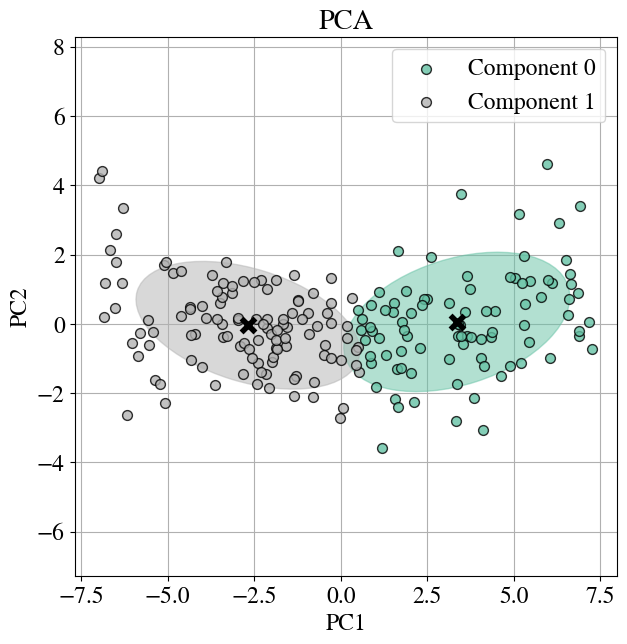

  0%|          | 0/500 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'covariance_type': 'tied', 'random_state': 436}
Best BIC score =  2099.546903221409


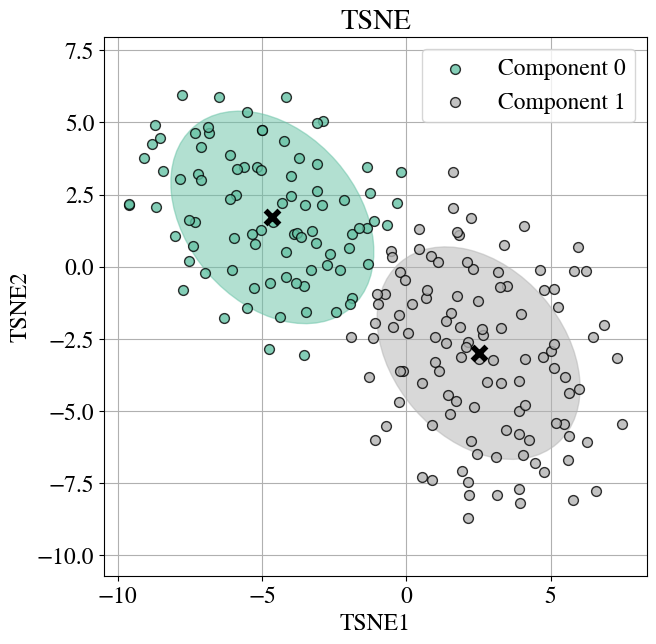

  0%|          | 0/500 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'covariance_type': 'tied', 'random_state': 154}
Best BIC score =  1276.9029694986393


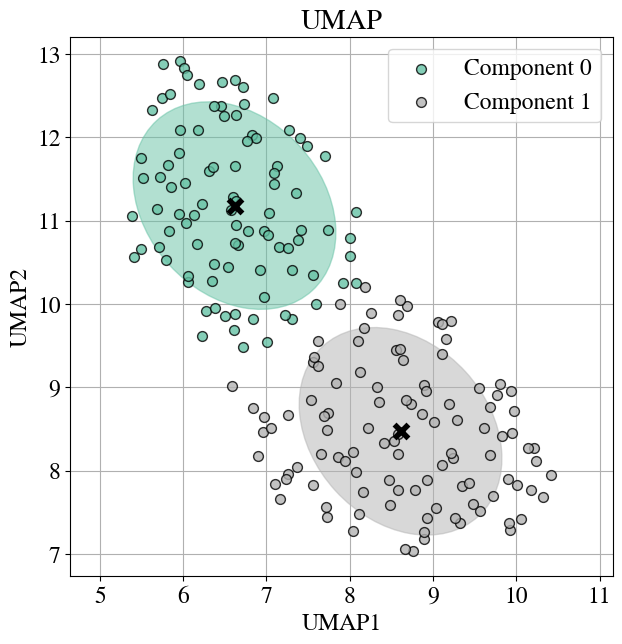

In [7]:
showcase_methods(cluster_mean_reps)

##### Spectral preclustering GMM results


- For the PCA representation:
  - $BIC = 1793.14085550949$
  - Covariance structure: full
- For the ΤSNE representation:
  - $BIC = 2099.14085550949$
  - Covariance structure: tied
- For the UMAP representation:
  - $BIC$ = 1276.9029694986393
  - Covariance structure: tied


#### **Suboption 3.: Leiden Clustering with user-defined resolution parameter for repeated analysis and intuitive result exploration**


The Leiden clustering algorithm is a very popular most popular method for single-cell clustering. Initially introduced in this [paper](https://www.nature.com/articles/s41598-019-41695-z), it represents an improvement over the Louvain clustering algorithm. Similar to the previously mentioned Spectral clustering, Leiden is a graph network-based clustering algorithm. However, its main focus lies in optimizing modularity, a measure of network or graph structure that determines the strength of clustering or community divisions. Networks with high modularity exhibit dense connections among nodes within modules while having sparse connections between nodes in different modules.

The most important hyperparameter for Leiden clsutering is:

- **Resolution:** The Leiden algorithm incorporates a resolution parameter that enables fine-tuning of the clustering granularity. Again much like UMAP and with same reasoning we allow the user to define this parameter in the context of the pipeline. This flexibility allows researchers to explore the cell communities at multiple resolution levels, produced fitted Gaussian models, interpret the results and repeat the analysis easily with few pipeline method calls if needed.


Below we showcase the result with a resolotuion of 0.2:


In [8]:
cluster_mean_reps = []
for X,method in zip(reps,['X_pca','X_tsne','X_umap']):
  sc.pp.neighbors(adata, use_rep=method)
  sc.tl.leiden(adata, resolution=0.4, key_added="leiden_"+ method)
  labels = adata.obs["leiden_"+ method]
  unique_labels = np.unique(labels)
  cluster_means = [np.mean(X[labels == label], axis=0) for label in unique_labels]
  cluster_means = np.array(cluster_means)  
  cluster_mean_reps.append(cluster_means)
cluster_mean_reps

[array([[-2.3572676 , -0.06488312],
        [ 3.9818726 ,  0.10959998]], dtype=float32),
 array([[ 0.668189  , -2.6886072 ],
        [-3.2361908 ,  0.6601006 ],
        [-6.562808  ,  3.380086  ],
        [ 4.385166  , -5.663434  ],
        [ 3.1410687 ,  0.33671877]], dtype=float32),
 array([[ 6.296172 , 11.805745 ],
        [ 9.500628 ,  7.941974 ],
        [ 7.02392  , 10.402273 ],
        [ 8.514028 ,  9.196654 ],
        [ 7.4925685,  8.159753 ]], dtype=float32)]

  0%|          | 0/500 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'covariance_type': 'full', 'random_state': 229}
Best BIC score =  1791.5081772574945


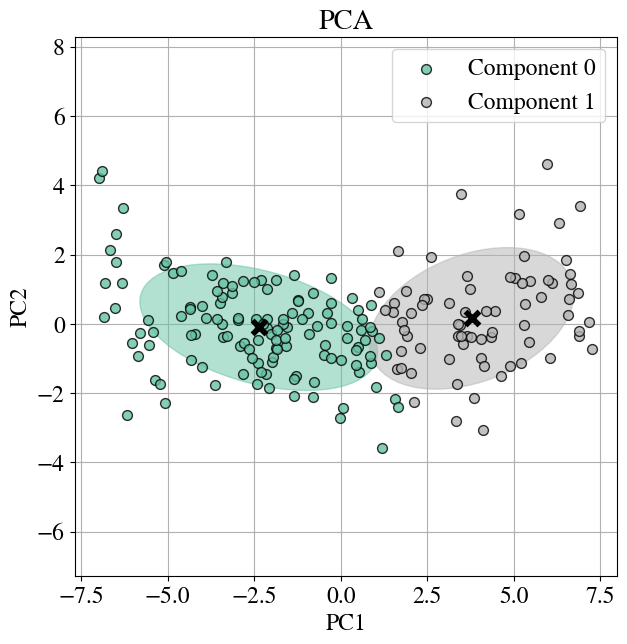

  0%|          | 0/500 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'covariance_type': 'tied', 'random_state': 254}
Best BIC score =  2128.7224274222463


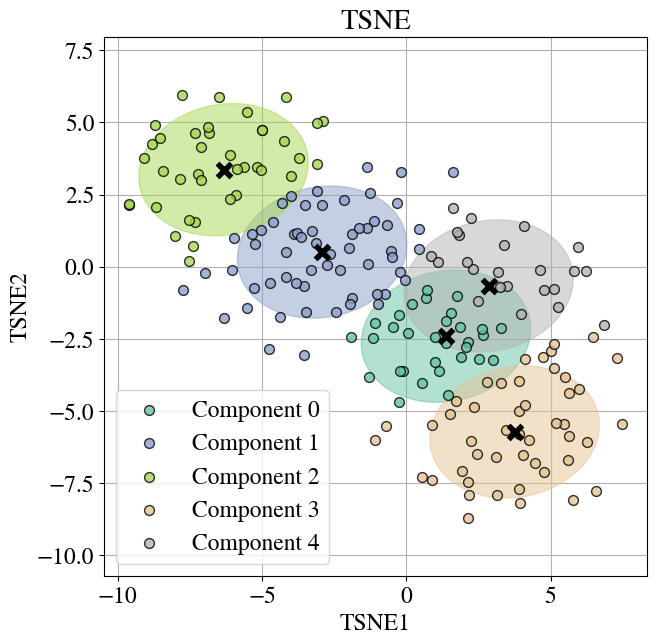

  0%|          | 0/500 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'covariance_type': 'tied', 'random_state': 284}
Best BIC score =  1279.6944908784174


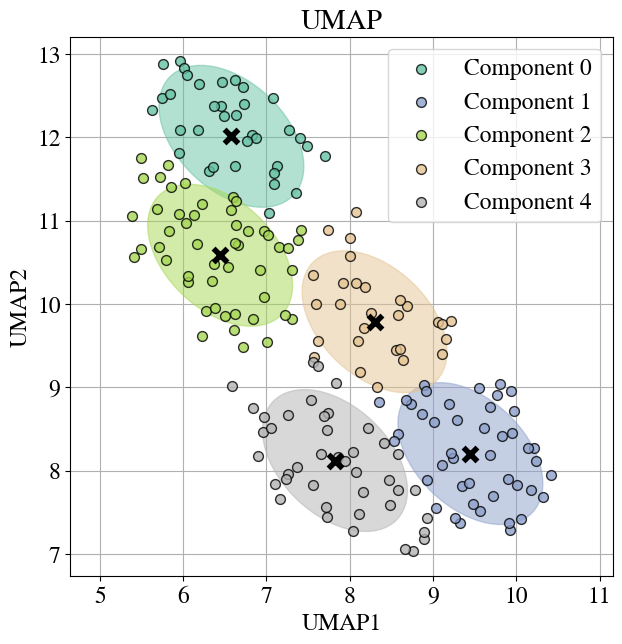

In [9]:
showcase_methods(cluster_mean_reps)

Αs you can notice the results are not optimal in the sense that excluding the GMM fitted model for the PCA representation the TSNE, UMAP based GMM models have much higher BIC scores. Of course this is to be expected since we have not done any other trials do identify a good resolution hyperparameter. This out of the scope for this showcased and will be explored further after the implementation of the pipeline.


### _Option 3.: Automatic optimization of both the number of components, as well as the covariance type via the use of BIC or AIC without any precomputed means._


This option as described above does not utilize preclustering but only the maximization of BIC or AIC to find the optimal number of components, covariance type , initialization method and random state for the GMM model.


  0%|          | 0/1000 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'n_components': 3, 'covariance_type': 'full', 'random_state': 998, 'init_params': 'random_from_data'}
Best BIC score =  1785.136201448789


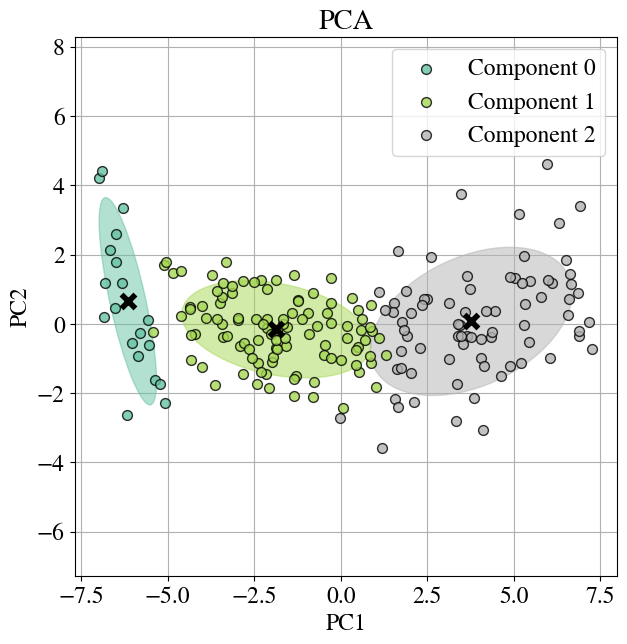

  0%|          | 0/1000 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'n_components': 2, 'covariance_type': 'tied', 'random_state': 495, 'init_params': 'kmeans'}
Best BIC score =  2099.552306854582


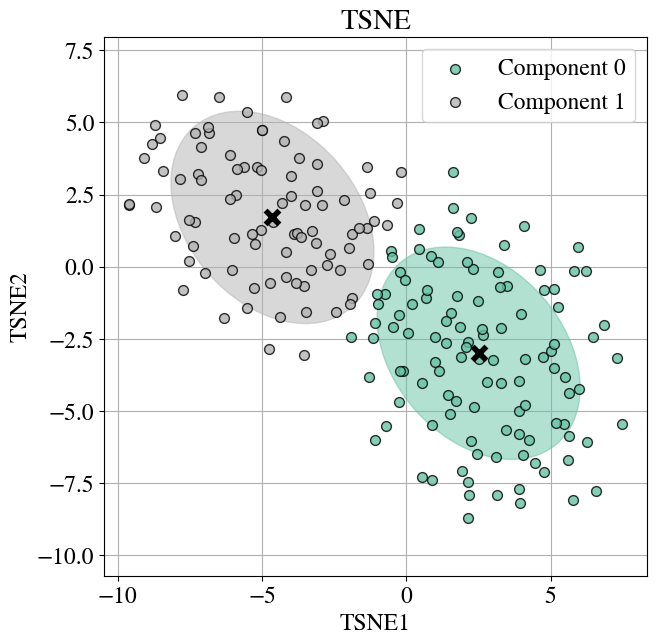

  0%|          | 0/1000 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'n_components': 3, 'covariance_type': 'tied', 'random_state': 951, 'init_params': 'kmeans'}
Best BIC score =  1274.1134216995506


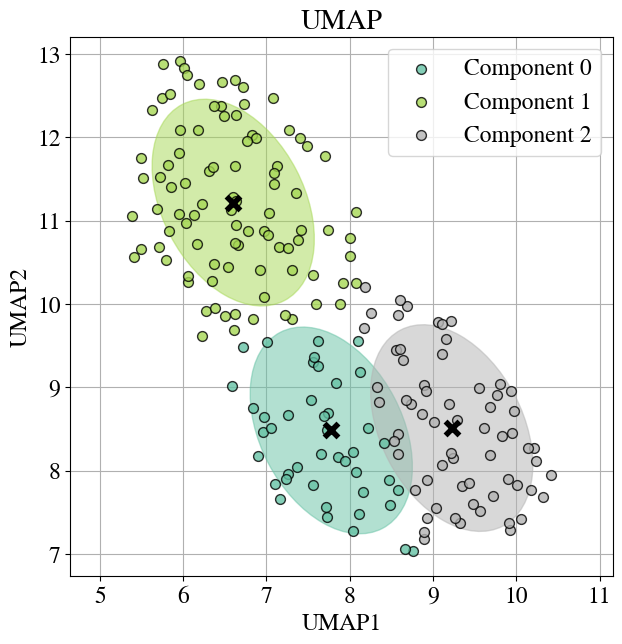

In [10]:
showcase_methods(not_precomputed_means=True)

As you can see the fully automated optimized


In [17]:
best_params, best_value, _  = optimizeGMM(X = X_pca,metric = "BIC",components_range =[2,10],n_trials=1000)
gmm = GaussianMixture(n_components= best_params['n_components'], init_params=best_params['init_params'],covariance_type= best_params['covariance_type'],random_state= best_params['random_state'],max_iter=100)
gmm.fit(X_pca)
gmm
filename = "models/example_gmm.pkl"
with open(filename, "wb") as file:
    pickle.dump(gmm, file)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
gmm

GaussianMixture(init_params='random_from_data', n_components=3,
                random_state=998)